In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 267 kB/s 


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, metrics, losses
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from functools import partial
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
import numpy as np
import SimpleITK as sitk
import pandas as pd

In [ ]:
rc('animation', html='jshtml')

# Global Variables


In [ ]:
os.chdir('/content/drive/MyDrive/nnfl')

In [ ]:
BATCH_SIZE = 2
EPOCHS = 5

In [ ]:
params = dict()
params['dstRes'] = np.asarray([1,1,1.5],dtype=float)
params['VolSize'] = np.asarray([128,128,64],dtype=int)
params['normDir'] = False

# Metrics:

In [ ]:
class JaccardIndex(metrics.Metric):
    def __init__(self, name='jaccard_index',threshold=0.5,**kwargs) -> None:
      super(JaccardIndex, self).__init__(name=name,**kwargs)
      self.ji = self.add_weight(name='JI', initializer='zeros',dtype='float64')
      self.count = self.add_weight(name='count', initializer='zeros',dtype='float64')
      self.threshold = threshold
        

    def update_state(self,y_true, y_pred, sample_weight=None):
      conf_mat = get_confusion_matrix(y_true,y_pred,self.threshold)
      self.ji.assign(self.count*self.ji)
      self.ji.assign_add(get_jaccard_index(conf_mat))
      self.count.assign_add(tf.constant(1.,dtype=tf.float64))
      self.ji.assign(self.ji/self.count)

    def result(self):        
        return self.ji

In [ ]:
class DiceIndex(metrics.Metric):
    def __init__(self, name='dice_index',threshold=0.5,**kwargs) -> None:
      super(DiceIndex, self).__init__(name=name, **kwargs)
      self.ji = self.add_weight(name='DI', initializer='zeros',dtype='float64')
      self.count = self.add_weight(name='count', initializer='zeros',dtype='float64')
      self.threshold = threshold
    
    def update_state(self,y_true, y_pred, sample_weight=None):
      conf_mat = get_confusion_matrix(y_true,y_pred,self.threshold)
      self.ji.assign(self.count*self.ji)
      self.ji.assign_add(get_dice_coefficient(conf_mat))
      self.count.assign_add(tf.constant(1.,dtype=tf.float64))
      self.ji.assign(self.ji/self.count)
        

    def result(self):
        return self.ji 


In [ ]:
class Sensitvity(tf.keras.metrics.Metric):
    def __init__(self, name='sensitivity',threshold=0.5,**kwargs) -> None:
      super(Sensitvity, self).__init__(name=name, **kwargs)
      self.ji = self.add_weight(name='SN', initializer='zeros',dtype='float64')
      self.count = self.add_weight(name='count', initializer='zeros',dtype='float64')
      self.threshold = threshold

    def update_state(self,y_true, y_pred, sample_weight=None):
      conf_mat = get_confusion_matrix(y_true,y_pred,self.threshold)
      self.ji.assign(self.count*self.ji)
      self.ji.assign_add(get_sensitivity(conf_mat))
      self.count.assign_add(tf.constant(1.,dtype=tf.float64))
      self.ji.assign(self.ji/self.count)
        

    def result(self):
        return self.ji 

In [ ]:
class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity',threshold=0.5,**kwargs) -> None:
      super(Specificity, self).__init__(name=name, **kwargs)
      self.ji = self.add_weight(name='SP', initializer='zeros',dtype='float64')
      self.count = self.add_weight(name='count', initializer='zeros',dtype='float64')
      self.threshold = threshold
        
    def update_state(self,y_true, y_pred, sample_weight=None):
      conf_mat = get_confusion_matrix(y_true,y_pred,self.threshold)
      self.ji.assign(self.count*self.ji)
      self.ji.assign_add(get_specificity(conf_mat))
      self.count.assign_add(tf.constant(1.,dtype=tf.float64))
      self.ji.assign(self.ji/self.count)
        
    def result(self):
        return self.ji

In [ ]:
class Accuracy(tf.keras.metrics.Metric):
    def __init__(self, name='Accuracy',threshold=0.5,**kwargs) -> None:
      super(Accuracy, self).__init__(name=name, **kwargs)
      self.ji = self.add_weight(name='AC', initializer='zeros',dtype='float64')
      self.count = self.add_weight(name='count', initializer='zeros',dtype='float64')
      self.threshold = threshold

    def update_state(self,y_true, y_pred, sample_weight=None):
      conf_mat = get_confusion_matrix(y_true,y_pred,self.threshold)
      self.ji.assign(self.count*self.ji)
      self.ji.assign_add(get_accuracy(conf_mat))
      self.count.assign_add(tf.constant(1.,dtype=tf.float64))
      self.ji.assign(self.ji/self.count)

    def result(self):
        return self.ji 

In [ ]:
def get_confusion_matrix(mask, prediction,threshold = None): 
    # y_pred,_ = tf.split(y_pred,num_or_size_splits=2, axis=4)
    assert(threshold)
    prediction = convert_to_ones_and_zeros(prediction,threshold)
    mask = convert_to_ones_and_zeros(mask)
    prediction = tf.reshape(prediction,[-1])
    mask = tf.reshape(mask,[-1])
    conf_mat = tf.math.confusion_matrix(mask,prediction)
    return conf_mat

In [ ]:
def convert_to_ones_and_zeros(image, threshold = None):
    if not tf.is_tensor(image): 
        image = tf.convert_to_tensor(image)
    if threshold:
        image = image > threshold
        return image
    image = image == tf.reduce_max(image)
    return image

In [ ]:
def get_dice_coefficient(confusion_matrix: np.ndarray):
    TP,FP,TN,FN = get_tuple(confusion_matrix)
    return 2*TP / (2*TP + FN + FP)

def get_jaccard_index(confusion_matrix: np.ndarray):
    TP,FP,TN,FN = get_tuple(confusion_matrix)
    return TP / (TP + FN + FP)

def get_sensitivity(confusion_matrix: np.ndarray):
    TP,FP,TN,FN = get_tuple(confusion_matrix)
    return TP / (TP + FN)

def get_specificity(confusion_matrix: np.ndarray):
    TP,FP,TN,FN = get_tuple(confusion_matrix)
    return TN / (TN + FP)

def get_accuracy(confusion_matrix: np.ndarray):
    TP,FP,TN,FN = get_tuple(confusion_matrix)
    return (TP + TN) / tf.reduce_sum(confusion_matrix)

def get_tuple(confusion_matrix):
    '''
        return: TP, FP, TN, FN 
    '''
    return confusion_matrix[1][1] ,confusion_matrix[0][1], confusion_matrix[0][0], confusion_matrix[1][0]


# Loss:

In [ ]:
class DiceLoss(losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    t2 = tf.reduce_sum(tf.square(y_true))
    p2 = tf.reduce_sum(tf.square(y_pred))
    tp = tf.reduce_sum(tf.math.multiply(y_true, y_pred))
    return tf.constant(1.0) - ((tf.constant(2.0)*tp + tf.constant(1.0)) / (t2 + p2 + tf.constant(1.0)))


In [ ]:
class JaccardLoss(losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    t2 = tf.reduce_sum(tf.square(y_true))
    p2 = tf.reduce_sum(tf.square(y_pred))
    tp = tf.reduce_sum(tf.math.multiply(y_true, y_pred))
    return tf.constant(1.0) - (tp / (t2 + p2 - tp))

In [ ]:
class L1LaplacianLoss(losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    laplace_kernel = tf.constant([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]], dtype=tf.float32)
    laplace_kernel = tf.reshape(laplace_kernel, (3,3, 1, 1))
    def convert_laplacian(x):
      img = []
      for d in range(x.shape[2]):
        temp = x[:,:,d]
        temp = tf.reshape(temp, (1,temp.shape[0], temp.shape[1],1))
        temp = tf.nn.conv2d(temp, laplace_kernel, strides=[1, 1, 1, 1], padding='SAME')
        temp = tf.reshape(temp, (temp.shape[1], temp.shape[2]))
        img.append(temp)
      return tf.stack(img, axis = 2)
    
    y_true = tf.map_fn(convert_laplacian, y_true)
    y_pred = tf.map_fn(convert_laplacian, y_pred)
    return tf.reduce_sum(tf.math.abs(y_true-y_pred))

In [ ]:
class L1SobelLoss(losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    def convert_sobel(x):
      img = []
      for d in range(x.shape[2]):
        temp = x[:,:,d]
        temp = tf.reshape(temp, (1,*temp.shape))
        temp = tf.image.sobel_edges(temp)
        img.append(temp)
      return tf.stack(img, axis = 3)
    
    y_true = tf.map_fn(convert_sobel, y_true)
    y_pred = tf.map_fn(convert_sobel, y_pred)
    return tf.reduce_sum(tf.math.abs(y_true-y_pred))

# Model:

In [ ]:
class VNet(Model):
  def __init__(self, input_shape, batch_size):
    super(VNet, self).__init__(name='VNet')
    self.batch_size = batch_size
    self.input_layer = layers.InputLayer(input_shape=(input_shape), batch_size=self.batch_size)
    
    self.l1_c1 = layers.Conv3D(16, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l1_o = layers.Conv3D(32, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn1 = layers.BatchNormalization()
    
    self.l2_c1 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l2_c2 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l2_o = layers.Conv3D(64, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn2 = layers.BatchNormalization()

    self.l3_c1 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_c2 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_c3 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_o = layers.Conv3D(128, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn3 = layers.BatchNormalization()

    self.l4_c1 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_c2 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_c3 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_o = layers.Conv3D(256, 2, strides=2)
    # self.bn4 = layers.BatchNormalization()

    self.l5_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_o = layers.Conv3DTranspose(256, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn5 = layers.BatchNormalization()

    self.l6_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_o = layers.Conv3DTranspose(128, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn6 = layers.BatchNormalization()

    self.l7_c1 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_c2 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_c3 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_o = layers.Conv3DTranspose(64, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn7 = layers.BatchNormalization()

    self.l8_c1 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l8_c2 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l8_o = layers.Conv3DTranspose(32, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn8 = layers.BatchNormalization()

    self.l9_c1 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l9_o = layers.Conv3D(2, 1, strides=1, padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l10 = layers.Conv3D(1, 1, strides=1, padding='same', activation='sigmoid')
      
        # self.l10 = layers.Softmax(axis=4)
  
  def call(self, input_tensor, training = False):

    input_tensor = self.input_layer(input_tensor)
    l1_c1 = self.l1_c1(input_tensor)
    l1_c1 = layers.Add()([l1_c1, input_tensor])
    l1_o = self.l1_o(l1_c1)
    # l1_o = self.bn1(l1_o)

    l2_c1 = self.l2_c1(l1_o)
    l2_c2 = self.l2_c2(l2_c1)
    l2_c2 = layers.Add()([l2_c2, l1_o])
    l2_o = self.l2_o(l2_c2)
    # l2_o = self.bn2(l2_o)

    l3_c1 = self.l3_c1(l2_o)
    l3_c2 = self.l3_c2(l3_c1)
    l3_c3 = self.l3_c3(l3_c2)
    l3_c3 = layers.Add()([l3_c3, l2_o])
    l3_o = self.l3_o(l3_c3)
    # l3_o = self.bn3(l3_o)

    l4_c1 = self.l4_c1(l3_o)
    l4_c2 = self.l4_c2(l4_c1)
    l4_c3 = self.l4_c3(l4_c2)
    l4_c3 = layers.Add()([l4_c3, l3_o])
    l4_o = self.l4_o(l4_c3)
    # l4_o = self.bn4(l4_o)

    l5_c1 = self.l5_c1(l4_o)
    l5_c2 = self.l5_c2(l5_c1)
    l5_c3 = self.l5_c3(l5_c2)
    l5_c3 = layers.Add()([l5_c3, l4_o])
    l5_o = self.l5_o(l5_c3)
    # l5_o = self.bn5(l5_o)

    l6_i = layers.Concatenate(axis=4)([l5_o, l4_c3])
    l6_c1 = self.l6_c1(l6_i)
    l6_c2 = self.l6_c2(l6_c1)
    l6_c3 = self.l6_c3(l6_c2)
    l6_c3 = layers.Add()([l6_c3, l5_o])
    l6_o = self.l6_o(l6_c3)
    # l6_o = self.bn6(l6_o)

    l7_i = layers.Concatenate(axis=4)([l6_o, l3_c3])
    l7_c1 = self.l7_c1(l7_i)
    l7_c2 = self.l7_c2(l7_c1)
    l7_c3 = self.l7_c3(l7_c2)
    l7_c3 = layers.Add()([l7_c3, l6_o])
    l7_o = self.l7_o(l7_c3)
    # l7_o = self.bn7(l7_o)

    l8_i = layers.Concatenate(axis=4)([l7_o, l2_c2])
    l8_c1 = self.l8_c1(l8_i)
    l8_c2 = self.l8_c2(l8_c1)
    l8_c2 = layers.Add()([l8_c2, l7_o])
    l8_o = self.l8_o(l8_c2)
    # l8_o = self.bn8(l8_o)

    l9_i = layers.Concatenate(axis=4)([l8_o, l1_c1])
    l9_c1 = self.l9_c1(l9_i)
    l9_c1 = layers.Add()([l9_c1, l8_o])
    l9_o = self.l9_o(l9_c1)
    

    # return l9_o
    return self.l10(l9_o)


In [ ]:
class VNet_without_skip(Model):
  def __init__(self, input_shape, batch_size):
    super(VNet_without_skip, self).__init__(name='VNet_without_skip')
    self.batch_size = batch_size
    self.input_layer = layers.InputLayer(input_shape=(input_shape), batch_size=self.batch_size)
    
    self.l1_c1 = layers.Conv3D(16, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l1_o = layers.Conv3D(32, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn1 = layers.BatchNormalization()
    
    self.l2_c1 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l2_c2 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l2_o = layers.Conv3D(64, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn2 = layers.BatchNormalization()

    self.l3_c1 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_c2 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_c3 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_o = layers.Conv3D(128, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn3 = layers.BatchNormalization()

    self.l4_c1 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_c2 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_c3 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_o = layers.Conv3D(256, 2, strides=2)
    # self.bn4 = layers.BatchNormalization()

    self.l5_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_o = layers.Conv3DTranspose(256, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn5 = layers.BatchNormalization()

    self.l6_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_o = layers.Conv3DTranspose(128, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn6 = layers.BatchNormalization()

    self.l7_c1 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_c2 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_c3 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_o = layers.Conv3DTranspose(64, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn7 = layers.BatchNormalization()

    self.l8_c1 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l8_c2 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l8_o = layers.Conv3DTranspose(32, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn8 = layers.BatchNormalization()

    self.l9_c1 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l9_o = layers.Conv3D(2, 1, strides=1, padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l10 = layers.Conv3D(1, 1, strides=1, padding='same', activation='sigmoid')
      
        # self.l10 = layers.Softmax(axis=4)
  
  def call(self, input_tensor, training = False):

    input_tensor = self.input_layer(input_tensor)
    l1_c1 = self.l1_c1(input_tensor)
    l1_c1 = layers.Add()([l1_c1, input_tensor])
    l1_o = self.l1_o(l1_c1)
    # l1_o = self.bn1(l1_o)

    l2_c1 = self.l2_c1(l1_o)
    l2_c2 = self.l2_c2(l2_c1)
    l2_c2 = layers.Add()([l2_c2, l1_o])
    l2_o = self.l2_o(l2_c2)
    # l2_o = self.bn2(l2_o)

    l3_c1 = self.l3_c1(l2_o)
    l3_c2 = self.l3_c2(l3_c1)
    l3_c3 = self.l3_c3(l3_c2)
    l3_c3 = layers.Add()([l3_c3, l2_o])
    l3_o = self.l3_o(l3_c3)
    # l3_o = self.bn3(l3_o)

    l4_c1 = self.l4_c1(l3_o)
    l4_c2 = self.l4_c2(l4_c1)
    l4_c3 = self.l4_c3(l4_c2)
    l4_c3 = layers.Add()([l4_c3, l3_o])
    l4_o = self.l4_o(l4_c3)
    # l4_o = self.bn4(l4_o)

    l5_c1 = self.l5_c1(l4_o)
    l5_c2 = self.l5_c2(l5_c1)
    l5_c3 = self.l5_c3(l5_c2)
    l5_c3 = layers.Add()([l5_c3, l4_o])
    l5_o = self.l5_o(l5_c3)
    # l5_o = self.bn5(l5_o)

    l6_i = l5_o
    l6_c1 = self.l6_c1(l6_i)
    l6_c2 = self.l6_c2(l6_c1)
    l6_c3 = self.l6_c3(l6_c2)
    l6_c3 = layers.Add()([l6_c3, l5_o])
    l6_o = self.l6_o(l6_c3)
    # l6_o = self.bn6(l6_o)

    l7_i = l6_o
    l7_c1 = self.l7_c1(l7_i)
    l7_c2 = self.l7_c2(l7_c1)
    l7_c3 = self.l7_c3(l7_c2)
    l7_c3 = layers.Add()([l7_c3, l6_o])
    l7_o = self.l7_o(l7_c3)
    # l7_o = self.bn7(l7_o)

    l8_i = l7_o
    l8_c1 = self.l8_c1(l8_i)
    l8_c2 = self.l8_c2(l8_c1)
    l8_c2 = layers.Add()([l8_c2, l7_o])
    l8_o = self.l8_o(l8_c2)
    # l8_o = self.bn8(l8_o)

    l9_i = l8_o
    l9_c1 = self.l9_c1(l9_i)
    l9_c1 = layers.Add()([l9_c1, l8_o])
    l9_o = self.l9_o(l9_c1)
    

    # return l9_o
    return self.l10(l9_o)


In [ ]:
class VNet_extra_block(Model):
  def __init__(self, input_shape, batch_size):
    super(VNet_extra_block, self).__init__(name='VNet_extra_block')
    self.batch_size = batch_size
    self.input_layer = layers.InputLayer(input_shape=(input_shape), batch_size=self.batch_size)
    
    self.l1_c1 = layers.Conv3D(16, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l1_o = layers.Conv3D(32, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn1 = layers.BatchNormalization()
    
    self.l2_c1 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l2_c2 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l2_o = layers.Conv3D(64, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn2 = layers.BatchNormalization()

    self.l3_c1 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_c2 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_c3 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l3_o = layers.Conv3D(128, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn3 = layers.BatchNormalization()

    self.l4_c1 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_c2 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_c3 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l4_o = layers.Conv3D(256, 2, strides=2)
    # self.bn4 = layers.BatchNormalization()

    self.e1_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.e1_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.e1_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.e1_o = layers.Conv3D(256, 2, strides=2)

    self.l5_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l5_o = layers.Conv3DTranspose(256, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn5 = layers.BatchNormalization()

    self.e2_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.e2_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.e2_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.e2_o = layers.Conv3DTranspose(256, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))

    self.l6_c1 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_c2 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_c3 = layers.Conv3D(256, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l6_o = layers.Conv3DTranspose(128, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn6 = layers.BatchNormalization()

    self.l7_c1 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_c2 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_c3 = layers.Conv3D(128, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l7_o = layers.Conv3DTranspose(64, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn7 = layers.BatchNormalization()

    self.l8_c1 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l8_c2 = layers.Conv3D(64, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l8_o = layers.Conv3DTranspose(32, 2, strides=2, activation=layers.PReLU(shared_axes=[1,2,3]))
    # self.bn8 = layers.BatchNormalization()

    self.l9_c1 = layers.Conv3D(32, 5, strides=1,padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l9_o = layers.Conv3D(2, 1, strides=1, padding='same', activation=layers.PReLU(shared_axes=[1,2,3]))
    self.l10 = layers.Conv3D(1, 1, strides=1, padding='same', activation='sigmoid')
      
        # self.l10 = layers.Softmax(axis=4)
  
  def call(self, input_tensor, training = False):

    input_tensor = self.input_layer(input_tensor)
    l1_c1 = self.l1_c1(input_tensor)
    l1_c1 = layers.Add()([l1_c1, input_tensor])
    l1_o = self.l1_o(l1_c1)
    # l1_o = self.bn1(l1_o)

    l2_c1 = self.l2_c1(l1_o)
    l2_c2 = self.l2_c2(l2_c1)
    l2_c2 = layers.Add()([l2_c2, l1_o])
    l2_o = self.l2_o(l2_c2)
    # l2_o = self.bn2(l2_o)

    l3_c1 = self.l3_c1(l2_o)
    l3_c2 = self.l3_c2(l3_c1)
    l3_c3 = self.l3_c3(l3_c2)
    l3_c3 = layers.Add()([l3_c3, l2_o])
    l3_o = self.l3_o(l3_c3)
    # l3_o = self.bn3(l3_o)

    l4_c1 = self.l4_c1(l3_o)
    l4_c2 = self.l4_c2(l4_c1)
    l4_c3 = self.l4_c3(l4_c2)
    l4_c3 = layers.Add()([l4_c3, l3_o])
    l4_o = self.l4_o(l4_c3)
    # l4_o = self.bn4(l4_o)

    e1_c1 = self.e1_c1(l4_o)
    e1_c2 = self.e1_c2(e1_c1)
    e1_c3 = self.e1_c3(e1_c2)
    e1_c3 = layers.Add()([e1_c3, l4_o])
    e1_o = self.e1_o(e1_c3)

    l5_c1 = self.l5_c1(e1_o)
    l5_c2 = self.l5_c2(l5_c1)
    l5_c3 = self.l5_c3(l5_c2)
    l5_c3 = layers.Add()([l5_c3, e1_o])
    l5_o = self.l5_o(l5_c3)
    # l5_o = self.bn5(l5_o)

    e2_i = layers.Concatenate(axis=4)([l5_o, e1_c3])
    e2_c1 = self.e2_c1(e2_i)
    e2_c2 = self.e2_c2(e2_c1)
    e2_c3 = self.e2_c3(e2_c2)
    e2_c3 = layers.Add()([e2_c3, l5_o])
    e2_o = self.e2_o(e2_c3)

    l6_i = layers.Concatenate(axis=4)([e2_o, l4_c3])
    l6_c1 = self.l6_c1(l6_i)
    l6_c2 = self.l6_c2(l6_c1)
    l6_c3 = self.l6_c3(l6_c2)
    l6_c3 = layers.Add()([l6_c3, e2_o])
    l6_o = self.l6_o(l6_c3)
    # l6_o = self.bn6(l6_o)

    l7_i = layers.Concatenate(axis=4)([l6_o, l3_c3])
    l7_c1 = self.l7_c1(l7_i)
    l7_c2 = self.l7_c2(l7_c1)
    l7_c3 = self.l7_c3(l7_c2)
    l7_c3 = layers.Add()([l7_c3, l6_o])
    l7_o = self.l7_o(l7_c3)
    # l7_o = self.bn7(l7_o)

    l8_i = layers.Concatenate(axis=4)([l7_o, l2_c2])
    l8_c1 = self.l8_c1(l8_i)
    l8_c2 = self.l8_c2(l8_c1)
    l8_c2 = layers.Add()([l8_c2, l7_o])
    l8_o = self.l8_o(l8_c2)
    # l8_o = self.bn8(l8_o)

    l9_i = layers.Concatenate(axis=4)([l8_o, l1_c1])
    l9_c1 = self.l9_c1(l9_i)
    l9_c1 = layers.Add()([l9_c1, l8_o])
    l9_o = self.l9_o(l9_c1)
    

    # return l9_o
    return self.l10(l9_o)


In [ ]:
# x = np.random.rand(1,128,128,64,1)
# x = tf.constant(x)
# mod = VNet_with_extra_layer(input_shape=(128,128,64,1,), batch_size=1)
# mod.compile()

# p = mod.predict(x)

# Data Pipeline:

CustomDataset class subclassing Tensorflow Dataset

In [ ]:
# Resizes raw images
def getNumpyData(params,dat,method):

  ret = np.zeros([params['VolSize'][0], params['VolSize'][1], params['VolSize'][2]], dtype=np.float32)

  img=dat

  #we rotate the image according to its transformation using the direction and according to the final spacing we want
  factor = np.asarray(img.GetSpacing()) / [params['dstRes'][0], params['dstRes'][1],
                                            params['dstRes'][2]]

  factorSize = np.asarray(img.GetSize() * factor, dtype=float)

  newSize = np.max([factorSize, params['VolSize']], axis=0)

  newSize = newSize.astype(dtype=int).tolist()
  
  T=sitk.AffineTransform(3)
  T.SetMatrix(img.GetDirection())

  resampler = sitk.ResampleImageFilter()
  resampler.SetReferenceImage(img)
  resampler.SetOutputSpacing([params['dstRes'][0], params['dstRes'][1], params['dstRes'][2]])
  resampler.SetSize(newSize)
  resampler.SetInterpolator(method)

  if params['normDir']:
    resampler.SetTransform(T.GetInverse())

  imgResampled = resampler.Execute(img)


  imgCentroid = np.asarray(newSize, dtype=float) / 2.0

  imgStartPx = (imgCentroid - params['VolSize'] / 2.0).astype(dtype=int).tolist()

  regionExtractor = sitk.RegionOfInterestImageFilter()
  regionExtractor.SetSize(list(params['VolSize'].astype(dtype=int).tolist()))
  regionExtractor.SetIndex(imgStartPx)

  imgResampledCropped = regionExtractor.Execute(imgResampled)

  ret = np.transpose(sitk.GetArrayFromImage(imgResampledCropped).astype(dtype=float), [2, 1, 0])

  return ret

In [ ]:
# convert axis zyx to xyz
def get_xyz(img):
  print(img.shape)
  z,y,x , t = img.shape
  rimg = np.empty((x,y,z))
  for ix in range(x):
    for iy in range(y):
      for iz in range(z):
        rimg[x,y,z,0] = img[z,y,x,0]
  return rimg

In [ ]:
class CustomDataset:

    def __init__(self, dir:str, out_shape = (128,128,64), image_channels = 1, mask_channels = 1, batch_size= 10):
      self.dir = dir
      self.image_channels = image_channels
      self.batch_size = batch_size
      self.mask_channels = mask_channels
      self.params = dict()
      self.params['dstRes'] = np.asarray([1,1,1.5],dtype=float)
      self.params['VolSize'] = np.asarray([*out_shape],dtype=int)
      self.params['normDir'] = False

    # loads data
    def load_data(self):
      images =  [f for f in os.listdir(self.dir) if 'segmentation' not in f and 'raw' not in f] 
      masks = [f for f in os.listdir(self.dir) if 'segmentation' in f and 'raw' not in f]
      images = sorted(images)
      masks = sorted(masks)
      return images , masks
    
    def process_img(self, filepaths):
      images = []
      # cwd = os.getcwd()
      # os.chdir(self.dir)
      for filepath in filepaths:
        rescalFilt=sitk.RescaleIntensityImageFilter()
        rescalFilt.SetOutputMaximum(1)
        rescalFilt.SetOutputMinimum(0)
        img = rescalFilt.Execute(sitk.Cast(sitk.ReadImage(self.dir+'/'+filepath),sitk.sitkFloat32))
        img = getNumpyData(self.params, img, sitk.sitkLinear)
        img = img.reshape(*img.shape, 1)
        img = (img-img.min()) / (img.max() - img.min())
        images.append(img)
      # os.chdir(cwd)
      images = np.array(images, dtype= np.float32)

      images =  tf.convert_to_tensor(images)
      return images

    def process_mask(self, maskpaths):
      # cwd = os.getcwd()
      # os.chdir(self.dir)
      masks = []
      for maskpath in maskpaths:
        mask = sitk.Cast(sitk.ReadImage(self.dir+'/'+maskpath),sitk.sitkFloat32)
        mask = getNumpyData(self.params, mask, sitk.sitkLinear)
        mask = (mask > 0.5)*1
        mask = (mask-mask.min()) / (mask.max() - mask.min())
        mask = mask.reshape(*mask.shape, 1)
        masks.append(mask)
      # os.chdir(cwd)
      masks = np.array(masks, dtype= np.float32)
      masks =  tf.convert_to_tensor(masks)
      return masks  

    # Call this to get the data
    def get_dataset(self):
      x,y = self.load_data()
      print(f"Total images:- {len(x)}, masks:- {len(y)}")
      x,y = self.process_img(x), self.process_mask(y)
      dataset = tf.data.Dataset.from_tensor_slices((x,y))
      dataset = dataset.shuffle(buffer_size=10)
      dataset = dataset.batch(batch_size=self.batch_size)
      return  dataset


In [ ]:
# show animation 
def ct_animation(img, path, isMask = False):
 
  # rc('animation', html='jshtml')
  fig = plt.figure()
  ip = np.random.rand(img.shape[0], img.shape[1])
  ip = (ip-ip.min()) / (ip.max() - ip.min())
  im = plt.imshow(ip, cmap = 'gray')

  def animate(i):
      im.set_array(img[:,:,i])
      return [im]

  anim = FuncAnimation(fig, animate, interval=50, blit=False, frames=img.shape[2], repeat=False)
  anim.save(f'{path}.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
  # plt.close()
  plt.show()
  return anim

In [ ]:
def plot_images(y):
  fig,ax = plt.subplots(8,8, figsize = (16,16))
  r,c = 0,0
  for i in range(64):
    ax[r,c].imshow(y[:,:,i], cmap = 'gray')
    c += 1
    if c == 8:
      c = 0
      r += 1
  plt.show()

In [ ]:
train = CustomDataset('/content/drive/MyDrive/nnfl/dataset/train', batch_size=BATCH_SIZE).get_dataset()

Total images:- 50, masks:- 50


In [ ]:
for x,y in train.take(1):
  print(x.shape,y.shape)
  x = x.numpy()
  x = x[0]
  x = x.reshape(128,128,64)
  y = y.numpy()
  y = y[0]
  y = y.reshape(128,128,64)
  print(x.shape,y.shape)

(2, 128, 128, 64, 1) (2, 128, 128, 64, 1)
(128, 128, 64) (128, 128, 64)


In [ ]:
# ct_animation(x, "x")

In [ ]:
# ct_animation(y,"y", True)

In [ ]:
# print("Image:")
# plot_images(x)
# print("Mask:")
# plot_images(y)

# Train Pipeline: 

In [ ]:
cmodels = [VNet, VNet_without_skip, VNet_extra_block]
closses = [DiceLoss, L1SobelLoss, L1LaplacianLoss]

cmodel_text = ['VNET', 'VNET_WITHOUT_SKIP', 'VNET_WITH_EXTRA_LAYER']
closs_text = ['DICE_LOSS', 'L1_SOBEL', 'L1_LAPLACIAN']

In [ ]:
train = CustomDataset('/content/drive/MyDrive/nnfl/dataset/train', batch_size=BATCH_SIZE).get_dataset()

Total images:- 50, masks:- 50


In [ ]:
# for mi, mode in zip(cmodel_text, cmodels):
#   for li, l in zip(closs_text, closses):
# mi = 
mod = VNet(input_shape=(128,128,64,1,), batch_size = BATCH_SIZE)
with open(f'logs/VNET_DICE_LOSS.csv', 'w+'):
  ...
csv_logger = tf.keras.callbacks.CSVLogger(f'logs/VNET_DICE_LOSS.csv')
optimizer = Adam(1e-5)
mod.compile(optimizer=optimizer, loss= DiceLoss(), metrics=['accuracy'],)
mod.fit(train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[csv_logger],verbose=2)

Epoch 1/5
25/25 - 91s - loss: 0.8819 - accuracy: 0.7431 - 91s/epoch - 4s/step
Epoch 2/5
25/25 - 67s - loss: 0.8803 - accuracy: 0.9558 - 67s/epoch - 3s/step
Epoch 3/5
25/25 - 69s - loss: 0.8724 - accuracy: 0.9416 - 69s/epoch - 3s/step
Epoch 4/5
25/25 - 70s - loss: 0.7744 - accuracy: 0.9132 - 70s/epoch - 3s/step
Epoch 5/5
25/25 - 70s - loss: 0.7380 - accuracy: 0.8655 - 70s/epoch - 3s/step


# Evaluation


In [ ]:
cmodel_text
closs_text

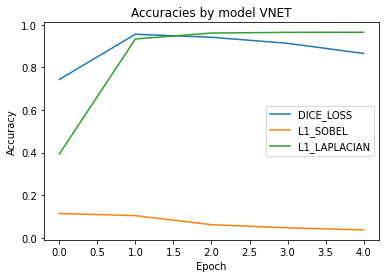

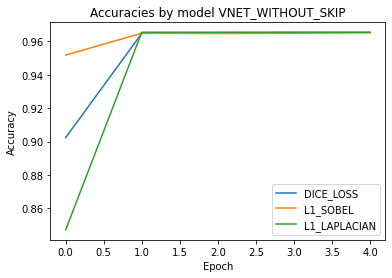

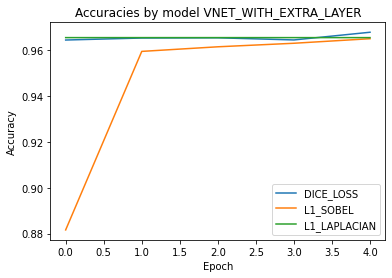

In [ ]:
for m in cmodel_text:
  plt.figure()
  plt.title(f"Accuracies by model {m}")
  for l in closs_text:
    df = pd.read_csv(f'logs/{m}_{l}.csv')
    plt.plot(df['epoch'],df['accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel("Accuracy")
  plt.legend(closs_text)
  plt.show()

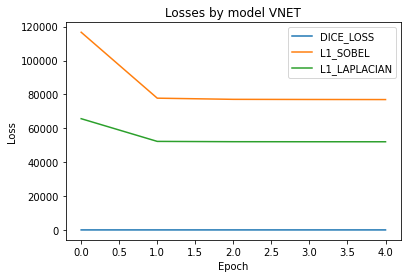

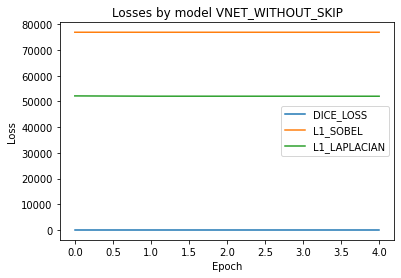

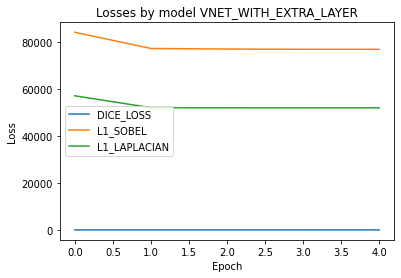

In [ ]:
for m in cmodel_text:
  plt.figure()
  plt.title(f"Losses by model {m}")
  for l in closs_text:
    df = pd.read_csv(f'logs/{m}_{l}.csv')
    plt.plot(df['epoch'],df['loss'])
  plt.xlabel('Epoch')
  plt.ylabel("Loss")
  plt.legend(closs_text)
  plt.show()